# Google Colab에서 필요한 라이브러리와 파일 업로드

In [ ]:
from google.colab import files
uploaded = files.upload()  # 전체 데이터 파일을 업로드합니다.

Saving sensor_log.csv to sensor_log.csv


# 필수 라이브러리 불러오기

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from openpyxl import Workbook

#**1. 데이터 불러오기**

In [ ]:
# 1. 데이터 로드
# 업로드한 파일을 읽어와서 전체 데이터를 저장합니다.
data = pd.read_csv("sensor_log.csv")

In [ ]:
# 데이터의 첫 몇 줄을 확인하여 제대로 불러왔는지 확인합니다.
print("Data:")
print(data.head())

Data:
  sensor_id   timestamp sensor_type      value status    location
0        S5  2024-01-01    Pressure  26.619538     OK  Location_A
1        S1  2024-01-02    Pressure  66.622623     OK  Location_C
2        S4  2024-01-03    Humidity  47.246473   WARN  Location_C
3        S4  2024-01-04    Pressure  42.534296     OK  Location_C
4        S4  2024-01-05    Pressure  62.251035     OK  Location_C


#**2. 데이터 전처리**

### One-Hot Encoding: 범주형 데이터를 숫자로 변환하기

In [95]:
# 1. sensor_id 컬럼 원핫 인코딩
sensor_id_dummies = pd.get_dummies(data['sensor_id'], prefix='sensor_id', dtype=int)
print("Encoded sensor_id (One-Hot Encoding):\n", sensor_id_dummies.head())

Encoded sensor_id (One-Hot Encoding):
    sensor_id_0  sensor_id_1  sensor_id_2  sensor_id_3  sensor_id_4
0            0            0            0            0            1
1            1            0            0            0            0
2            0            0            0            1            0
3            0            0            0            1            0
4            0            0            0            1            0


In [96]:
# 2. sensor_type 컬럼 원핫 인코딩
sensor_type_dummies = pd.get_dummies(data['sensor_type'], prefix='sensor_type', dtype=int)
print("\nEncoded sensor_type (One-Hot Encoding):\n", sensor_type_dummies.head())


Encoded sensor_type (One-Hot Encoding):
    sensor_type_0  sensor_type_1  sensor_type_2
0              0              1              0
1              0              1              0
2              1              0              0
3              0              1              0
4              0              1              0


In [97]:
# 3. location 컬럼 원핫 인코딩
location_dummies = pd.get_dummies(data['location'], prefix='location', dtype=int)
print("\nEncoded location (One-Hot Encoding):\n", location_dummies.head())


Encoded location (One-Hot Encoding):
    location_0  location_1  location_2
0           1           0           0
1           0           0           1
2           0           0           1
3           0           0           1
4           0           0           1


In [ ]:
# 모든 인코딩이 완료된 후 최종 데이터 확인
print("\nFinal Encoded Data:")
print(data.head())


Final Encoded Data:
   sensor_id   timestamp  sensor_type      value status  location
0          4  2024-01-01            1  26.619538     OK         0
1          0  2024-01-02            1  66.622623     OK         2
2          3  2024-01-03            0  47.246473   WARN         2
3          3  2024-01-04            1  42.534296     OK         2
4          3  2024-01-05            1  62.251035     OK         2


In [98]:
# 원핫 인코딩된 데이터들을 기존 데이터와 합치기
data = pd.concat([data, sensor_id_dummies, sensor_type_dummies, location_dummies], axis=1)

# 원핫 인코딩 전의 원본 컬럼 제거
data.drop(['sensor_id', 'sensor_type', 'location'], axis=1, inplace=True)

# 결과 확인
print("\nData after One-Hot Encoding:\n", data.head())


Data after One-Hot Encoding:
     timestamp      value  status  sensor_id_0  sensor_id_1  sensor_id_2  \
0  2024-01-01  26.619538       0            0            0            0   
1  2024-01-02  66.622623       0            1            0            0   
2  2024-01-03  47.246473       0            0            0            0   
3  2024-01-04  42.534296       0            0            0            0   
4  2024-01-05  62.251035       0            0            0            0   

   sensor_id_3  sensor_id_4  sensor_type_0  sensor_type_1  sensor_type_2  \
0            0            1              0              1              0   
1            0            0              0              1              0   
2            1            0              1              0              0   
3            1            0              0              1              0   
4            1            0              0              1              0   

   location_0  location_1  location_2  
0           1        

###  타겟 변수 변환

In [ ]:
# 예측 목표인 status 컬럼을 이진값으로 변환하여 모델이 예측할 수 있도록 합니다.
# 'ERROR'는 1로, 'OK'와 'WARN'은 0으로 변환합니다.
data['status'] = data['status'].apply(lambda x: 1 if x == 'ERROR' else 0)
print("\nEncoded status (target variable):")
print(data[['status']].head())  # 변환된 결과를 확인합니다.


Encoded status (target variable):
   status
0       0
1       0
2       0
3       0
4       0


### 변수 선택

In [ ]:
# 모델이 학습한 데이터와 예측을 평가할 데이터를 나누는 단계입니다.
X = data.drop(columns=['status','timestamp'])  # 예측에 사용할 변수 (feature) 만 남기고 제거
y = data['status']                 # 예측 대상인 타겟 변수 (label)

### 학습 데이터와 테스트 데이터로 분리


In [ ]:
## 학습 데이터와 테스트 데이터로 분리 (80% 학습, 20% 테스트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("\nData Split:")
print(f"Training data: {len(X_train)} rows")
print(f"Testing data: {len(X_test)} rows")


Data Split:
Training data: 80 rows
Testing data: 20 rows


#**3. 랜덤포레스트 모델 학습**

#### 모델을 학습시키기 위해 RandomForestClassifier 객체를 생성하고 학습을 진행합니다.

In [ ]:
# 모델 생성: 랜덤 포레스트를 100개의 결정 나무(n_estimators=100)로 구성하고, 각 트리의 깊이를 10으로 제한합니다.
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# 모델 학습: 학습 데이터를 사용하여 모델을 학습시킵니다.
model.fit(X_train, y_train)
print("\nModel training complete.")


Model training complete.


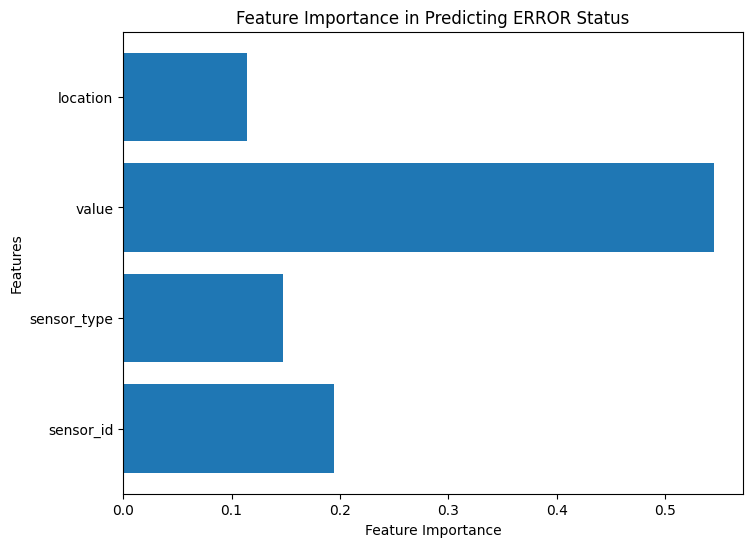


Feature Importances:
        Feature  Importance
2        value    0.544477
0    sensor_id    0.194497
1  sensor_type    0.147186
3     location    0.113840


In [99]:
# 변수 중요도 출력
feature_importances = model.feature_importances_

# 변수 중요도 시각화
plt.figure(figsize=(8, 6))
plt.barh(X.columns, feature_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Predicting ERROR Status")
plt.show()

# 변수 중요도 값 출력
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
print("\nFeature Importances:\n", importance_df.sort_values(by="Importance", ascending=False))

#**4. 예측 수행**

In [ ]:
# 학습된 모델을 사용하여 테스트 데이터에 대해 예측을 수행합니다.
y_pred = model.predict(X_test)
print("\nPredictions on test data complete.")


Predictions on test data complete.


#**5. 모델 평가**

#### 예측 결과를 평가하기 위해 여러 지표를 사용하여 모델 성능을 분석합니다.

In [ ]:
# 정확도(Accuracy): 전체 예측 중 맞춘 비율
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9


In [ ]:
# 정밀도(Precision): 'ERROR'라고 예측한 것 중 실제로 'ERROR'였던 비율
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

Precision: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# 재현율(Recall): 실제 'ERROR' 상태 중 모델이 올바르게 'ERROR'로 예측한 비율
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

Recall: 0.0


In [ ]:
# F1-Score: 정밀도와 재현율의 조화 평균
f1 = f1_score(y_test, y_pred)
print("F1-Score:", f1)

F1-Score: 0.0


In [ ]:
# 전체 지표를 포함한 성능 요약
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95        18
           1       0.00      0.00      0.00         2

    accuracy                           0.90        20
   macro avg       0.45      0.50      0.47        20
weighted avg       0.81      0.90      0.85        20



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# 혼동 행렬: 예측의 정확성과 오류를 한눈에 확인
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Confusion Matrix:
 [[18  0]
 [ 2  0]]


#**6. 모델 튜닝**

In [ ]:
# 1. 오버샘플링 적용
# Error 데이터를 여러 번 복제하여 불균형 문제를 해결
error_data = df[df['status'] == 'ERROR']
non_error_data = df[df['status'] != 'ERROR']

# Error 데이터를 복제하여 다수의 데이터와 비슷한 비율로 맞춥니다.
balanced_data = pd.concat([non_error_data, error_data.sample(len(non_error_data), replace=True)], ignore_index=True)

In [ ]:
# 오버샘플링된 데이터를 다시 X, y로 설정
X_balanced = balanced_data[['value']]
y_balanced = balanced_data['status'].apply(lambda x: 1 if x == 'ERROR' else 0)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# 오버샘플링 결과 확인
print("Original Class Distribution:")
print(df['status'].value_counts())  # 원본 데이터의 클래스 비율 출력
print("\nBalanced Class Distribution (After Oversampling):")
print(balanced_data['status'].value_counts())  # 오버샘플링 후 클래스 비율 출력

Original Class Distribution:
status
OK       68
WARN     25
ERROR     7
Name: count, dtype: int64

Balanced Class Distribution (After Oversampling):
status
ERROR    93
OK       68
WARN     25
Name: count, dtype: int64


In [ ]:
# 오버샘플링된 데이터를 X_balanced, y_balanced로 재설정
X_balanced = balanced_data[['value']]
y_balanced = balanced_data['status'].apply(lambda x: 1 if x == 'ERROR' else 0)

In [ ]:
# 2. 데이터 분할
# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# 분할 결과 확인
print("\nTraining set class distribution:")
print(y_train.value_counts())  # 학습 데이터 클래스 비율 확인
print("\nTest set class distribution:")
print(y_test.value_counts())  # 테스트 데이터 클래스 비율 확인



Training set class distribution:
status
0    67
1    63
Name: count, dtype: int64

Test set class distribution:
status
1    30
0    26
Name: count, dtype: int64


In [ ]:
# 3. 랜덤 포레스트 모델 학습
# 하이퍼파라미터 조정된 모델을 생성하고 학습을 진행합니다.
tuned_model = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=5, random_state=42)
tuned_model.fit(X_train, y_train)

# 모델 학습 완료 메시지 출력
print("\nModel training complete.")


Model training complete.


In [ ]:
# 4. 예측 및 평가
# 테스트 데이터에 대한 예측 수행
y_pred = tuned_model.predict(X_test)

# 분류 보고서 출력
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        26
           1       0.94      1.00      0.97        30

    accuracy                           0.96        56
   macro avg       0.97      0.96      0.96        56
weighted avg       0.97      0.96      0.96        56



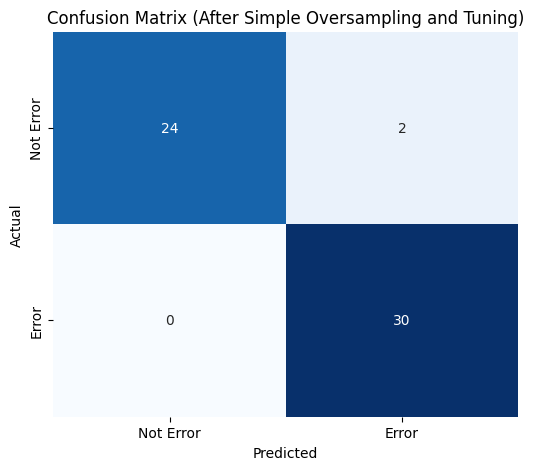

In [ ]:
# 혼동 행렬 생성 및 시각화
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Not Error", "Error"], yticklabels=["Not Error", "Error"])
plt.title("Confusion Matrix (After Simple Oversampling and Tuning)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#**7. 예측 결과 저장**

In [ ]:
# 예측 결과를 Excel 파일로 저장하여 추후 분석에 활용합니다.

# 테스트 데이터에 실제 값과 예측 값을 함께 저장하여 비교할 수 있도록 합니다.
test_results = X_test.copy()  # 테스트 데이터를 복사하여 새로운 DataFrame 생성
test_results['Actual Status'] = y_test.values  # 실제 상태 추가
test_results['Predicted Status'] = y_pred  # 예측된 상태 추가

# 예측 결과 미리 확인
print("\nPreview of Prediction Results:")
print(test_results.head())  # 결과표의 첫 몇 줄을 출력하여 확인

# 예측 결과를 Excel 파일로 저장합니다.
output_file = "sensor_log_predictions.xlsx"
test_results.to_excel(output_file, index=False)

print(f"\n예측 결과가 {output_file} 파일에 저장되었습니다.")


Preview of Prediction Results:
         value  Actual Status  Predicted Status
113  54.752608              1                 1
164  54.752608              1                 1
169  35.658456              1                 1
101  45.161319              1                 1
100  28.774880              1                 1

예측 결과가 sensor_log_predictions.xlsx 파일에 저장되었습니다.


Saving sensor_log.csv to sensor_log (5).csv
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        26
           1       0.94      1.00      0.97        30

    accuracy                           0.96        56
   macro avg       0.97      0.96      0.96        56
weighted avg       0.97      0.96      0.96        56



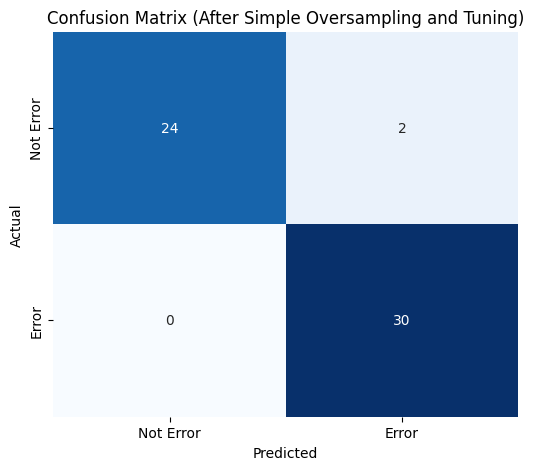

In [ ]:


# 오버샘플링 적용
# Error 데이터를 여러 번 복제하여 불균형 문제를 해결
error_data = df[df['status'] == 'ERROR']
non_error_data = df[df['status'] != 'ERROR']

# Error 데이터를 복제하여 다수의 데이터와 비슷한 비율로 맞춥니다.
balanced_data = pd.concat([non_error_data, error_data.sample(len(non_error_data), replace=True)], ignore_index=True)

# 오버샘플링된 데이터를 다시 X, y로 설정
X_balanced = balanced_data[['value']]
y_balanced = balanced_data['status'].apply(lambda x: 1 if x == 'ERROR' else 0)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# 모델 학습
tuned_model = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=5, random_state=42)
tuned_model.fit(X_train, y_train)

# 예측 및 평가
y_pred = tuned_model.predict(X_test)
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Not Error", "Error"], yticklabels=["Not Error", "Error"])
plt.title("Confusion Matrix (After Simple Oversampling and Tuning)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
혼동 행렬 (Confusion Matrix)
혼동 행렬은 모델의 예측 결과를 시각적으로 보여주는 표입니다.

가로축 (Predicted): 모델이 예측한 값입니다.
Not Error: 모델이 Not Error (정상 상태)로 예측한 샘플 수
Error: 모델이 Error 상태로 예측한 샘플 수
세로축 (Actual): 실제 값입니다.
Not Error: 실제 Not Error 상태인 샘플 수
Error: 실제 Error 상태인 샘플 수